### Importing modules

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import os


os.makedirs('models', exist_ok=True)

### Get the Dataset

In [8]:
ticker_symbol = 'TSLA'
dataset_path = os.path.join('dataset', f'{ticker_symbol}-stock.csv')

tesla_data = pd.read_csv(dataset_path)
tesla_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684 entries, 0 to 2683
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2684 non-null   object 
 1   Open       2684 non-null   float64
 2   High       2684 non-null   float64
 3   Low        2684 non-null   float64
 4   Close      2684 non-null   float64
 5   Adj Close  2684 non-null   float64
 6   Volume     2684 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 146.9+ KB


In [9]:
tesla_data['Date'] = pd.to_datetime(tesla_data['Date'])
tesla_data.set_index('Date', inplace=True)

### Visualising the Data

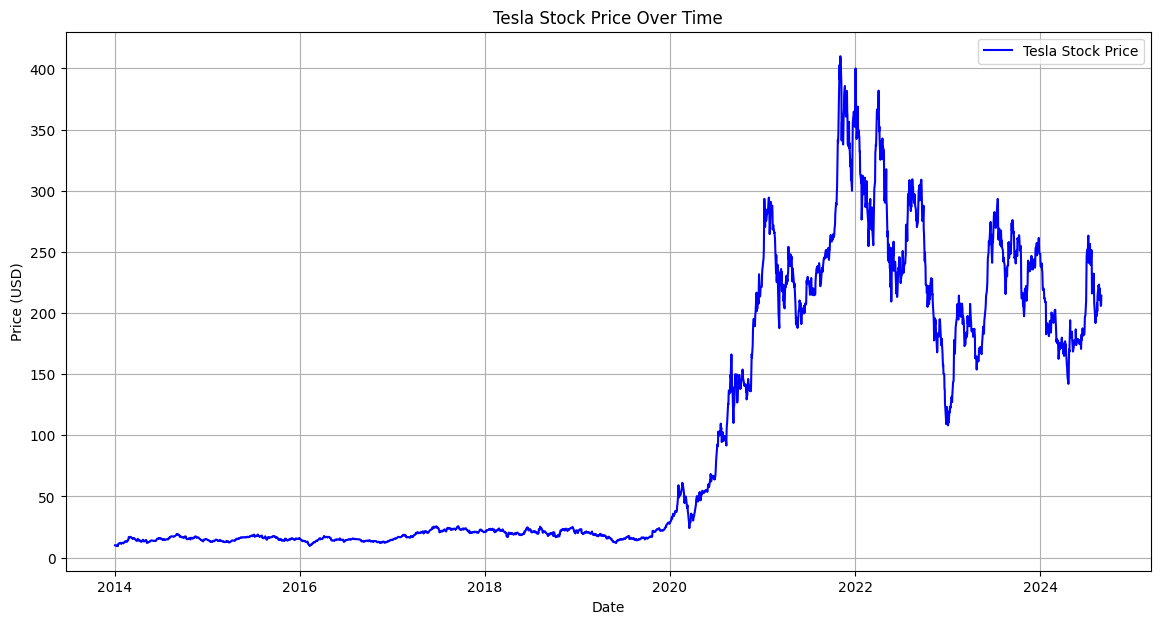

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Plotting the closing price of Tesla stock
plt.figure(figsize=(14, 7))
plt.plot(tesla_data['Close'], label='Tesla Stock Price', color='blue')
plt.title('Tesla Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

### Splitting into train and test sets

In [11]:
# Define the split dates
train_end_date = '2024-08-01'

# Create train and test datasets
train_data = tesla_data.loc[:train_end_date]  # Data from start to before '2024-08-01'
test_data = tesla_data.loc[train_end_date:]    # Data from '2024-08-01' onwards

train_size = len(train_data)
test_size = len(test_data)

In [12]:
os.makedirs('split_data_for_lstm', exist_ok=True)

train_data_path = os.path.join('split_data_for_lstm', 'train_data.csv')
test_data_path = os.path.join('split_data_for_lstm', 'test_data.csv')

train_data.to_csv(train_data_path, index=True)
test_data.to_csv(test_data_path, index=True)

### Scaling the data

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))



# Create training sequences
def create_dataset(data, time_step=1):
    X, y = [], []
    lim = len(data) - time_step - 1
    for i in range(lim):
        a = data[i:(i + time_step), 0]
        X.append(a)
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Set time step
time_step = 60  # You can adjust this value

X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshaping for LSTM input

### Saving Preprocessor Object

In [14]:
preprocessor_path = os.path.join('models', 'preprocessor_for_lstm.joblib')

# Saving the preprocessor object
joblib.dump(scaler, preprocessor_path)

['models/preprocessor_for_lstm.joblib']

### Building the LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Training the Model

In [17]:
model.fit(X, y, epochs=60, batch_size=75)

Epoch 1/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0376
Epoch 2/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
Epoch 3/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029
Epoch 4/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0029
Epoch 5/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0026
Epoch 6/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023
Epoch 7/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024
Epoch 8/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022
Epoch 9/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023
Epoch 10/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0022
Epoch 11/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0021
Epoch 12/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020
Epoch 13/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0019
Epoch 14/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020
Epoch 15/60
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019
Epoc

### Saving the Model

In [18]:
model_path = os.path.join('models', 'LSTM_model.keras')

# Saving the model
model.save(model_path)